In [267]:
!pip install wandb

In [268]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
import wandb
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [269]:
dataset_path = '/content/drive/MyDrive/Face_recognition/7-7 dataset-20211011T142227Z-001/7-7 dataset'

##hyper parameter

In [270]:
batch_size = 32
epochs = 10
width = height = 150

In [271]:
data_generation = ImageDataGenerator(rescale = 1./255,
                                    # horizontal_flip = True,
                                     validation_split= 0.2,
                                    fill_mode = 'nearst')

In [272]:
train_data = data_generation.flow_from_directory(
    dataset_path,
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    subset= 'training'
)

Found 1091 images belonging to 14 classes.


In [273]:
val_data = data_generation.flow_from_directory(
    dataset_path,
    target_size = (width,height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False,
    subset= 'validation'
)

Found 268 images belonging to 14 classes.


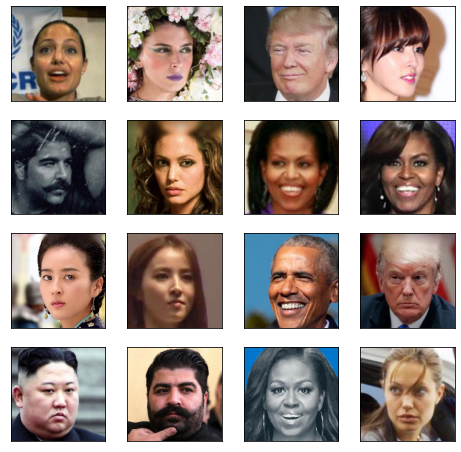

In [274]:
train_images = next(train_data)[0]
plt.figure(figsize = (8,8))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i] , cmap = plt.cm.binary)

In [275]:
train_data.image_shape

(150, 150, 3)

In [276]:
# train_data = tf.data.Dataset.from_tensor_slices((train_data)).shuffle(100).batch(32)
# test_data = tf.data.Dataset.from_tensor_slices((val_data)).batch(32)

In [277]:
class MYModel(tf.keras.Model):
  def __init__(self,number_of_classes):
      super().__init__()
      self.conv1 = Conv2D(32,(3,3),activation='relu', input_shape = (width ,height ,3))
      self.conv2 = Conv2D(64,(3,3), activation='relu')
      self.conv3 = Conv2D(128,(3,3),activation='relu')

      self.maxp1  = MaxPooling2D(2)
      self.maxp2 = MaxPooling2D(2)
      self.conv4 = Conv2D(128,(3,3),activation='relu')
      self.conv5 = Conv2D(256,(3,3),activation='relu')
      
      self.flatten = Flatten()
      self.fc1 = Dense(128,activation='relu')
      self.fc2 = Dense(number_of_classes, activation = 'sigmoid')
  def call(self,x):
      #x.shape = 28*28
      a = self.conv1(x)
      #y.shape = 32*26*26
      b = self.conv2(a)
      c = self.conv3(b)
      e = self.maxp2(c)
      d=self.conv4(e)
      e = self.maxp2(d)
      f = self.conv5(e)
      
      w=self.flatten(f)
      #w.shape=21632
      z = self.fc1(w)
      #z.shape = 1*128
      output = self.fc2(z)
      #output.shape = 1*14
      return output
model = MYModel(14)


In [278]:
wandb.init(project="Face_Detection")

config = wandb.config
config.learning_rate = 0.001

In [279]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer =  tf.keras.optimizers.Adam(learning_rate=config.learning_rate)

In [280]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalAccuracy(name = 'train_acc')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.CategoricalAccuracy(name = 'test_acc')

In [281]:
def train_step(images,y):
    with tf.GradientTape() as tape:
        y_pred = model(images,training = True)
        loss = loss_function(y,y_pred)
    #gradient calculate
    gradients = tape.gradient(loss, model.trainable_variables)
    #update
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    train_loss(loss)
    train_acc(y, y_pred)
    

In [282]:
def test_step(images,y):
    y_pred = model(images,training = False)
    loss = loss_function(y,y_pred)

    test_loss(loss)
    test_acc(y, y_pred)

In [283]:
from tqdm import tqdm

In [286]:
def train():
    epochs = 40
    c1 = 0
    c2 = 0
    for epoch  in range(epochs):
        train_loss.reset_state()
        train_acc.reset_state()

        test_loss.reset_state()
        test_acc.reset_state()
        
        for images,labels in train_data:
            train_step(images, labels)
            c1 += 1
            if c1 > 39:
                break
        print('epochs:',epoch+1)
        print('train_loss:', train_loss.result())
        print('train_accuracy:', train_acc.result(),'\n')

        for images,labels in val_data:
            test_step(images, labels) 
            c2 += 1
            if c2 > 39:
                break
        # print('----------------------------------------------------------------------\n')
        print('val_loss:', test_loss.result())
        print('val_acc:', test_acc.result())
        print('-----------------------------------------------------------------------\n')

In [287]:
#fit
train()

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


epochs: 1
train_loss: tf.Tensor(0.90998113, shape=(), dtype=float32)
train_accuracy: tf.Tensor(0.71702635, shape=(), dtype=float32) 

val_loss: tf.Tensor(0.8875068, shape=(), dtype=float32)
val_acc: tf.Tensor(0.7075, shape=(), dtype=float32)
-----------------------------------------------------------------------

epochs: 2
train_loss: tf.Tensor(0.32812953, shape=(), dtype=float32)
train_accuracy: tf.Tensor(0.9375, shape=(), dtype=float32) 

val_loss: tf.Tensor(1.026675, shape=(), dtype=float32)
val_acc: tf.Tensor(0.71875, shape=(), dtype=float32)
-----------------------------------------------------------------------

epochs: 3
train_loss: tf.Tensor(0.6257302, shape=(), dtype=float32)
train_accuracy: tf.Tensor(0.84375, shape=(), dtype=float32) 

val_loss: tf.Tensor(0.28080812, shape=(), dtype=float32)
val_acc: tf.Tensor(0.875, shape=(), dtype=float32)
-----------------------------------------------------------------------

epochs: 4
train_loss: tf.Tensor(0.36043808, shape=(), dtype=flo